In [1]:
import pandas as pd
import numpy as np
import pyhomogeneity as hg
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from scipy.stats import skew, t
%config Completer.use_jedi = False #for auto complete code 

In [2]:
obs=pd.read_csv('../data/precp/completada/gauge_completada.csv',sep=',')
#obs['Fecha'] = pd.to_datetime(obs['Fecha'], dayfirst=True)
obs['Fecha'] = pd.to_datetime(obs['Fecha'])
obs.set_index('Fecha',inplace=True)
obs.head()

,chusis,chalaco,huamarca,huancabamba,miraflores
Fecha,,,,,
1980-01-01,0.0,0.0,0.4,2.1,0.0
1980-01-02,0.0,0.0,0.0,0.0,0.0
1980-01-03,0.0,0.0,0.0,1.5,0.0
1980-01-04,0.0,0.0,0.0,0.0,0.0
1980-01-05,0.0,0.0,0.0,0.0,0.0


# Distribución de datos vacios en la base de datos

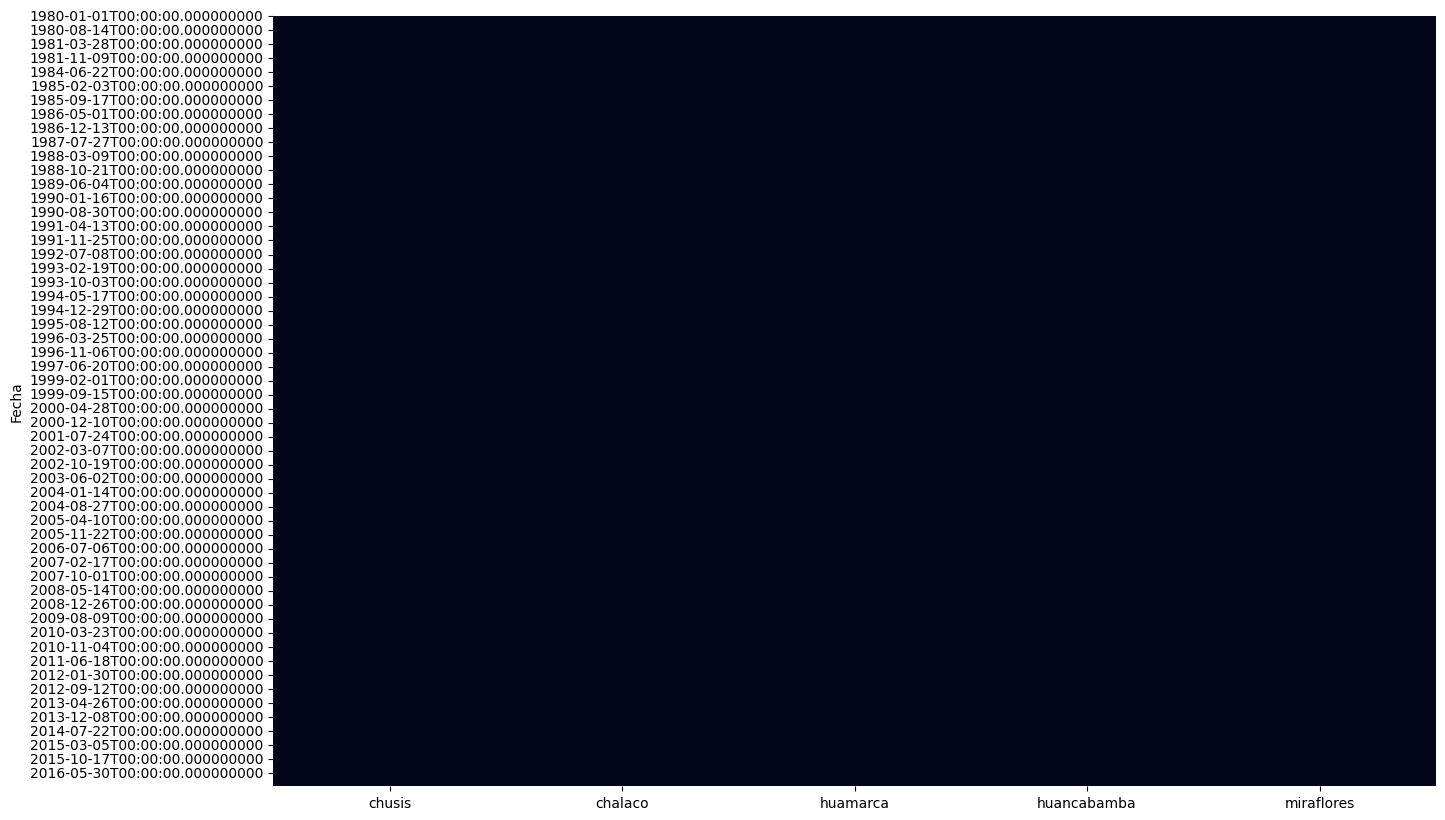

In [3]:
plt.figure(figsize=(15,10))
sns.heatmap(obs.isnull(), cbar=False)
plt.show()

# Remover años El Niño

In [5]:
def remove_years(df, years_to_remove):
    # Convert the index to datetime if it is not already
    df.index = pd.to_datetime(df.index)
    
    # Filter out the rows where the year of the index is in the years_to_remove list
    #df_filtered = df[~df.year.isin(years_to_remove)]
    df_filtered = df[~df.index.year.isin(years_to_remove)]
    
    return df_filtered


# List of years to remove
years_to_remove = [1982,1983,1998,2017]

# Remove the specified years
df_cleaned = remove_years(obs, years_to_remove)

# Display the result
df_cleaned.head(10)


,chusis,chalaco,huamarca,huancabamba,miraflores
Fecha,,,,,
1980-01-01,0.0,0.0,0.4,2.1,0.0
1980-01-02,0.0,0.0,0.0,0.0,0.0
1980-01-03,0.0,0.0,0.0,1.5,0.0
1980-01-04,0.0,0.0,0.0,0.0,0.0
1980-01-05,0.0,0.0,0.0,0.0,0.0
1980-01-06,0.0,0.0,0.0,0.0,0.0
1980-01-07,0.0,2.2,0.0,0.0,0.0
1980-01-08,0.0,0.0,0.0,0.0,0.0
1980-01-09,0.0,0.0,0.2,0.0,0.0


# Doble Masa

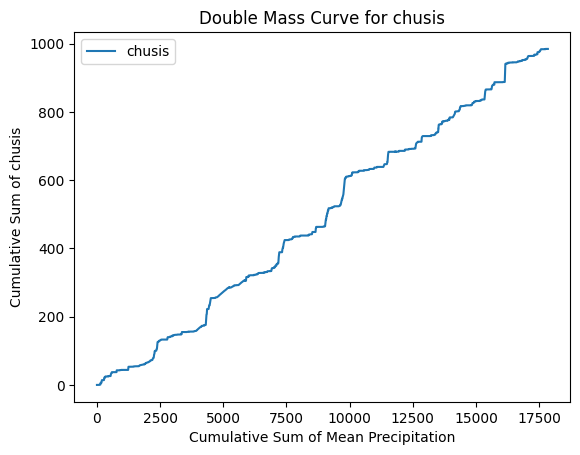

C:\Users\Usuario\AppData\Local\Temp\ipykernel_12252\1564275571.py:32: RuntimeWarning: invalid value encountered in divide
  derivative = np.diff(cumulative_sum) / np.diff(cumulative_mean)


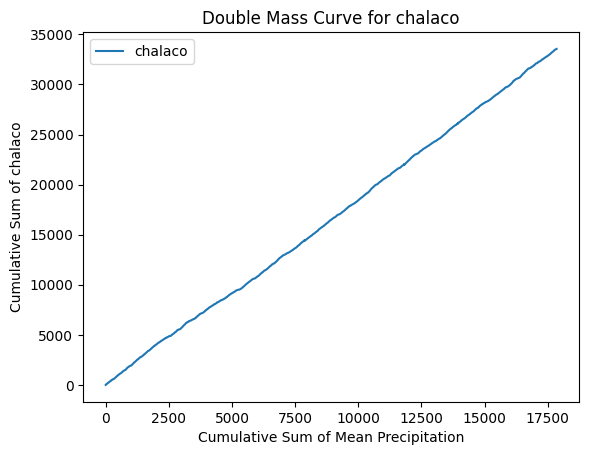

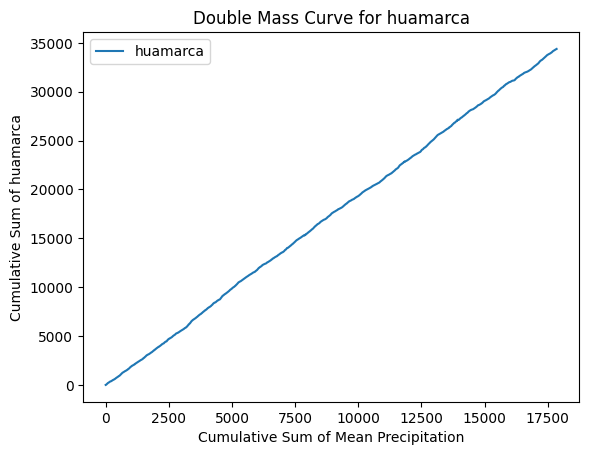

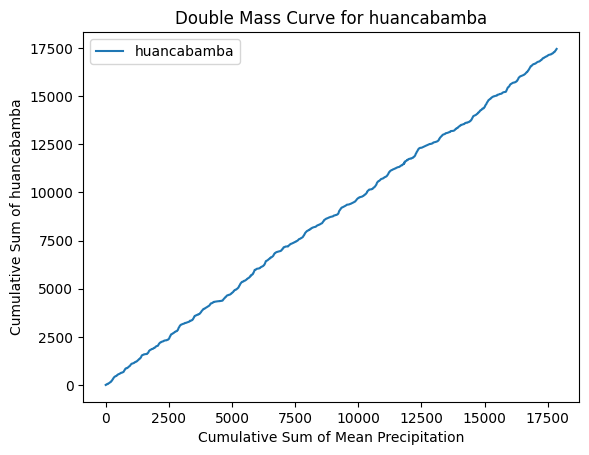

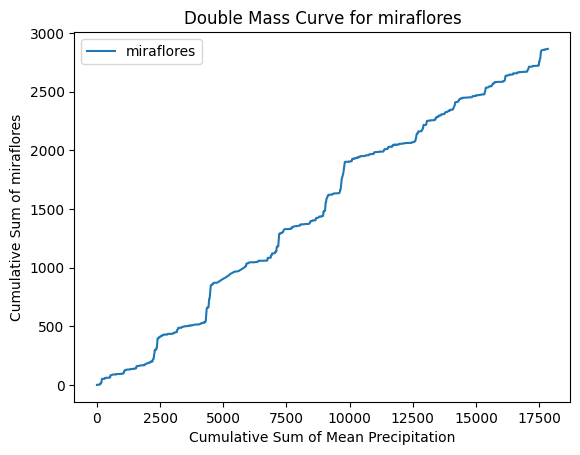

{'chusis': [], 'chalaco': [], 'huamarca': [], 'huancabamba': [], 'miraflores': []}


In [6]:
def identify_breaks_dmc(df):
    # Ensure the first column is in datetime format
    #df.iloc[:, 0] = pd.to_datetime(df.iloc[:, 0])
    
    # Create a copy of the DataFrame to avoid SettingWithCopyWarning
    df_copy = df.copy()
    
    # Calculate the mean of all gauge stations and add it to the copy DataFrame
    df_copy['Mean'] = df_copy.iloc[:, 0:].mean(axis=1)
    
    # Initialize a dictionary to store results
    breaks_dict = {}
    
    # Calculate cumulative sum of the mean column
    cumulative_mean = df_copy['Mean'].cumsum()
    
    # Iterate over each gauge station, excluding the mean column
    for col in df_copy.columns[0:-1]:
        # Calculate the cumulative sums for the gauge station
        cumulative_sum = df_copy[col].cumsum()
        
        # Plot the double mass curve for visual inspection (optional)
        plt.figure()
        plt.plot(cumulative_mean, cumulative_sum, label=col)
        plt.xlabel('Cumulative Sum of Mean Precipitation')
        plt.ylabel(f'Cumulative Sum of {col}')
        plt.title(f'Double Mass Curve for {col}')
        plt.legend()
        plt.show()
        
        # Identify breaks in the slope using changes in the derivative
        derivative = np.diff(cumulative_sum) / np.diff(cumulative_mean)
        breaks = np.where(np.abs(np.diff(derivative)) > np.mean(np.abs(np.diff(derivative))) + 2 * np.std(np.abs(np.diff(derivative))))[0]
        
        # Store the indices of the breaks in the dictionary
        breaks_dict[col] = list(breaks + 1)  # +1 to account for the shift caused by np.diff
    
    return breaks_dict

# Example usage:
# Assuming df_cleaned is the filtered DataFrame from the previous step
#breaks = identify_breaks_dmc(df_cleaned)
df_cleaned = obs
breaks = identify_breaks_dmc(df_cleaned)

# Display the result
print(breaks)

# Análisis anual de puntos de cambio con 3 test estadísticos

Para realizar los test se anaualizo los datos de la BD

| Mostrar Tabla     |
|    Resumida       |
+-------------------+

| Display Summary   |
|     Table         |
+-------------------+


In [7]:
df_year = df_cleaned.groupby(df_cleaned.index.to_period('Y')).sum()
def perform_tests_summary(df_cleaned):
    stations = df_cleaned.columns[0:]  # Exclude the date column
    summary_data = []

    for station in stations:
        pettitt_res = hg.pettitt_test(df_cleaned[[station]], alpha=0.01)
        snht_res = hg.snht_test(df_cleaned[[station]], sim=100000)
        buishand_res = hg.buishand_u_test(df_cleaned[[station]])

        summary_data.append({
            'Station': station,
            'Pettitt_CP': pettitt_res.cp,
            'Pettitt_Hypothesis': pettitt_res.h,
            'Pettitt_Mean_Pre': np.round(pettitt_res.avg.mu1,2),
            'Pettitt_Mean_Post': np.round(pettitt_res.avg.mu2,2),
            'Pettitt_p_value': pettitt_res.p,
            'SNHT_CP': snht_res.cp,
            'SNHT_Hypothesis': snht_res.h,
            'SNHT_Mean_Pre': np.round(snht_res.avg.mu1,2),
            'SNHT_Mean_Post': np.round(snht_res.avg.mu2,2),
            'SNHT_p_value': snht_res.p,
            'Buishand_CP': buishand_res.cp,
            'Buishand_Hypothesis': buishand_res.h,
            'Buishand_Mean_Pre': np.round(buishand_res.avg.mu1,2),
            'Buishand_Mean_Post': np.round(buishand_res.avg.mu2,2),
            'Buishand_p_value': buishand_res.p
        })

    summary_df = pd.DataFrame(summary_data)
    return summary_df

# Assuming df_cleaned is already defined and contains your cleaned data
summary_table = perform_tests_summary(df_year)

# Display the summary table
summary_table

,Station,Pettitt_CP,Pettitt_Hypothesis,Pettitt_Mean_Pre,Pettitt_Mean_Post,Pettitt_p_value,SNHT_CP,SNHT_Hypothesis,SNHT_Mean_Pre,SNHT_Mean_Post,SNHT_p_value,Buishand_CP,Buishand_Hypothesis,Buishand_Mean_Pre,Buishand_Mean_Post,Buishand_p_value
0,chusis,15,False,22.06,34.42,0.38045,10,False,17.32,33.82,0.52755,10,False,17.32,33.82,0.41785
1,chalaco,15,True,808.86,1127.30,0.00325,15,True,808.86,1127.30,0.01888,15,True,808.86,1127.30,0.01300
2,huamarca,15,False,867.56,1124.86,0.21375,10,False,813.13,1093.93,0.37234,15,False,867.56,1124.86,0.10160
3,huancabamba,11,False,409.57,562.95,0.02810,11,False,409.57,562.95,0.07005,11,False,409.57,562.95,0.06430
4,miraflores,10,False,52.89,97.33,0.43220,10,False,52.89,97.33,0.86083,10,False,52.89,97.33,0.81035


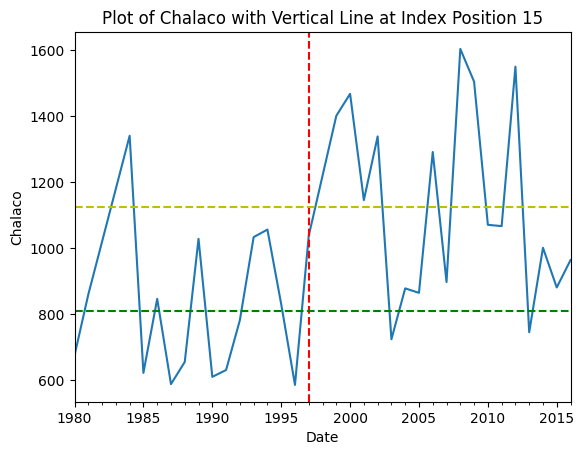

In [43]:
# Plot the 'chalaco' column
df_year['chalaco'].plot()
# Get the index position 15
index_position_15 = df_year.index[15]

# Plot a vertical line at index position 15
plt.axvline(x=index_position_15, color='r', linestyle='--')
plt.axhline(y=808.865333, color='g', linestyle='--')
plt.axhline(y=1125.048947, color='y', linestyle='--')


# Show the plot
plt.title('Plot of Chalaco with Vertical Line at Index Position 15')
plt.xlabel('Date')
plt.ylabel('Chalaco')
plt.show()

# Correción de los datos de chalaco

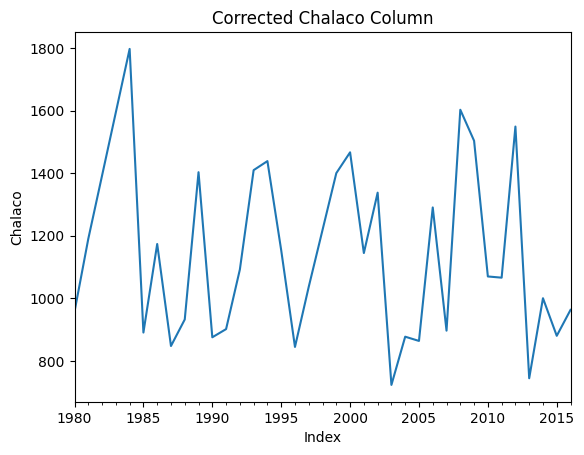

In [10]:
# Calculate mean and standard deviation for period 1 (before index 15)
mean_period_1 = df_year['chalaco'].iloc[:15].mean()
std_dev_period_1 = df_year['chalaco'].iloc[:15].std()

# Calculate mean and standard deviation for period 2 (after index 15)
mean_period_2 = df_year['chalaco'].iloc[15:].mean()
std_dev_period_2 = df_year['chalaco'].iloc[15:].std()

# Shift values using the formula: (P1 - m1) / s1 * s2 + m2
df_corrected = df_year.copy()
df_corrected.iloc[:15, df_corrected.columns.get_loc('chalaco')] = ((df_year['chalaco'].iloc[:15] - mean_period_1) / std_dev_period_1) * std_dev_period_2 + mean_period_2

# Plot the 'chalaco' column
df_corrected['chalaco'].plot()
plt.xlabel('Index')
plt.ylabel('Chalaco')
plt.title('Corrected Chalaco Column')
plt.show()

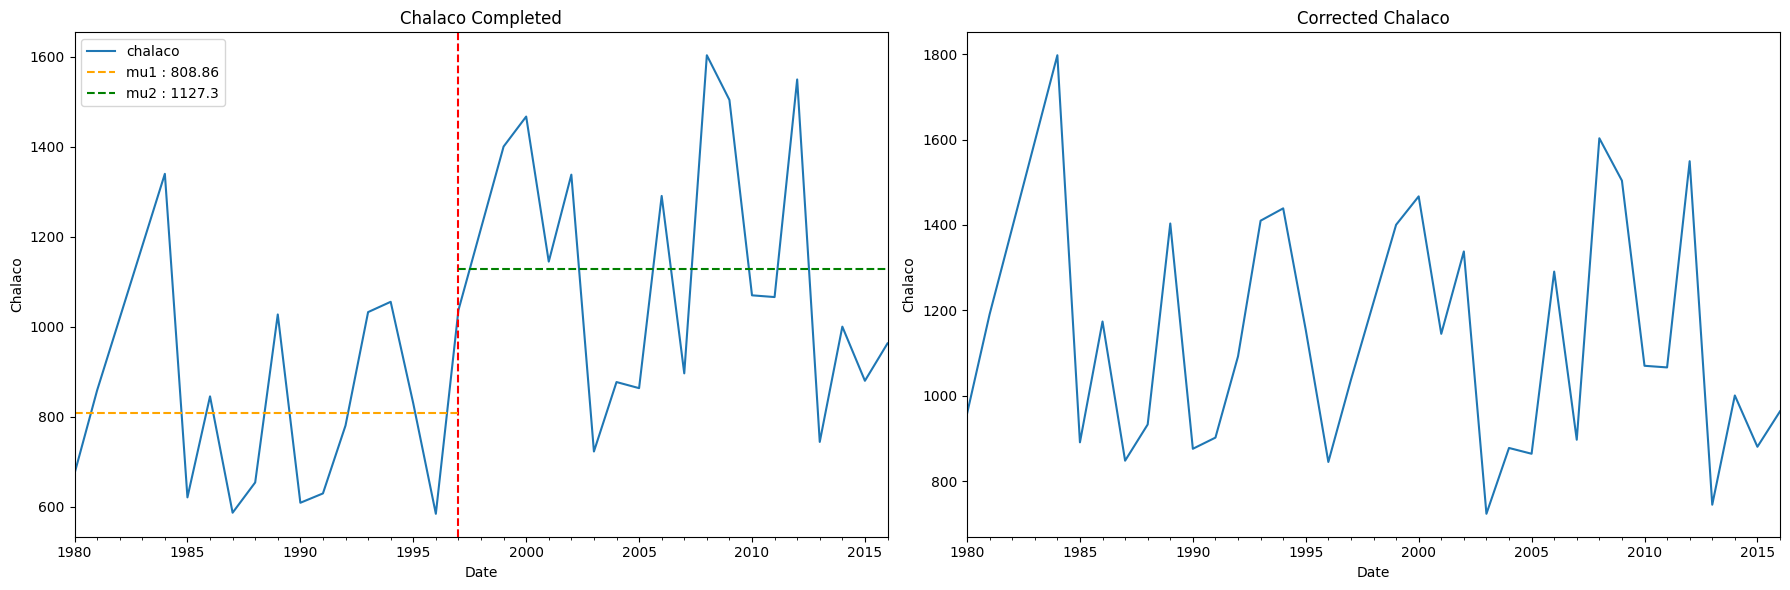

In [28]:
# Create the subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Plot the original 'chalaco' column
df_year['chalaco'].plot(ax=ax1)

# Define positions
index_position_15 = df_year.index[15]
mn = df_year.index[0]
mx = df_year.index[-1]
loc = df_year.index[15]

# Add vertical and horizontal lines
ax1.axvline(x=index_position_15, color='r', linestyle='--')
ax1.hlines(mean_period_1, xmin=mn, xmax=loc, colors='orange', linestyles='--', lw=1.5, label='mu1 : ' + str(round(mean_period_1, 2)))
ax1.hlines(mean_period_2, xmin=loc, xmax=mx, colors='green', linestyles='--', lw=1.5, label='mu2 : ' + str(round(mean_period_2, 2)))

ax1.set_title('Chalaco Completed')
ax1.set_xlabel('Date')
ax1.set_ylabel('Chalaco')
ax1.legend()

# Plot the corrected 'chalaco' column
df_corrected['chalaco'].plot(ax=ax2)
ax2.set_xlabel('Date')
ax2.set_ylabel('Chalaco')
ax2.set_title('Corrected Chalaco')

# Adjust layout and save the plot
plt.tight_layout()
plt.savefig('../data/results/plots/chalaco_combined.png', dpi=1200)
plt.show()